# Tutorial

In this notebook, we will see how to pass your own encoder and decoder's architectures to your VAE model using pythae!

In [34]:
# If you run on colab uncomment the following line
#!pip install git+https://github.com/clementchadebec/benchmark_VAE.git

In [35]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get the data

In [48]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True, transform=None)
n_samples = 10000
dataset = mnist_trainset.data.reshape(-1, 1, 28, 28)[:n_samples] / 255.

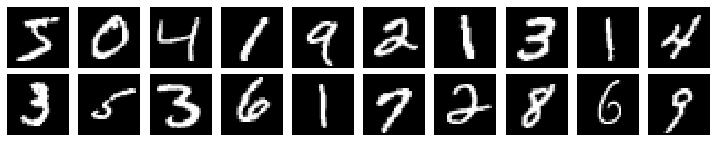

In [49]:
fig, axes = plt.subplots(2, 10, figsize=(10, 2))
for i in range(2):
        for j in range(10):
                axes[i][j].matshow(dataset[i*10 +j].reshape(28, 28), cmap='gray')
                axes[i][j].axis('off')

plt.tight_layout(pad=0.8)

## Let's build a custom auto-encoding architecture!

### First thing, you need to import the ``BaseEncoder`` and ``BaseDecoder`` as well as ``ModelOutput`` classes from pythae by running

In [50]:
from pythae.models.nn import BaseEncoder, BaseDecoder
from pythae.models.base.base_utils import ModelOutput

### Then build your own architectures

In [51]:
import torch.nn as nn


class Encoder_Conv_VAE_MNIST(BaseEncoder):
    def __init__(self, args):
        BaseEncoder.__init__(self)

        self.input_dim = (1, 28, 28)
        self.latent_dim = args.latent_dim
        self.n_channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.n_channels, 128, 4, 2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 4, 2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )

        self.embedding = nn.Linear(1024, args.latent_dim)
        self.log_var = nn.Linear(1024, args.latent_dim)

    def forward(self, x: torch.Tensor):
        h1 = self.conv_layers(x).reshape(x.shape[0], -1)
        output = ModelOutput(
            embedding=self.embedding(h1),
            log_covariance=self.log_var(h1)
        )
        return output


class Decoder_Conv_AE_MNIST(BaseDecoder):
    def __init__(self, args):
        BaseDecoder.__init__(self)
        self.input_dim = (1, 28, 28)
        self.latent_dim = args.latent_dim
        self.n_channels = 1

        self.fc = nn.Linear(args.latent_dim, 1024 * 4 * 4)
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 3, 2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 3, 2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, self.n_channels, 3, 2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z: torch.Tensor):
        h1 = self.fc(z).reshape(z.shape[0], 1024, 4, 4)
        output = ModelOutput(reconstruction=self.deconv_layers(h1))

        return output

### Define a model configuration (in which the latent will be stated). Here, we use the RHVAE model.

In [52]:
from pythae.models import VAEConfig

model_config = VAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=16
    )

### Build your encoder and decoder

In [53]:
encoder = Encoder_Conv_VAE_MNIST(model_config)
decoder= Decoder_Conv_AE_MNIST(model_config)

### Last but not least. Build you RHVAE model by passing the ``encoder`` and ``decoder`` arguments

In [54]:
from pythae.models import VAE

model = VAE(
    model_config=model_config,
    encoder=encoder,
    decoder=decoder
)

### Now you can see the model that you've just built contains the custom autoencoder and decoder

In [55]:
model

VAE(
  (decoder): Decoder_Conv_AE_MNIST(
    (fc): Linear(in_features=16, out_features=16384, bias=True)
    (deconv_layers): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (7): Sigmoid()
    )
  )
  (encoder): Encoder_Conv_VAE_MNIST(
    (conv_layers): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 256, kernel_size=(4, 4),

### *note*: If you want to launch a training of such a model, try to ensure that the provided architectures are suited for the data. pythae performs a model sanity check before launching training and raises an error if the model cannot encode and decode an input data point

## Train the model !

In [56]:
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines import TrainingPipeline

### Build the training pipeline with your ``TrainingConfig`` instance

In [57]:
training_config = BaseTrainerConfig(
    output_dir='my_model_with_custom_archi',
    learning_rate=1e-3,
    batch_size=200,
    steps_saving=None,
    num_epochs=10)

In [58]:
pipeline = TrainingPipeline(
    model=model,
    training_config=training_config)

### Launch the ``Pipeline``

In [59]:
torch.manual_seed(8)
torch.cuda.manual_seed(8)

pipeline(
    train_data=dataset
)

Preprocessing train data...
Using Base Trainer

! No eval dataset provided ! -> keeping best model on train.

Model passed sanity check !

Created my_model_with_custom_archi/VAE_training_2022-06-14_09-45-29. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/10:   0%|          | 0/50 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 96.0062
--------------------------------------------------------------------------


Training of epoch 2/10:   0%|          | 0/50 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.3627
--------------------------------------------------------------------------


Training of epoch 3/10:   0%|          | 0/50 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.521
--------------------------------------------------------------------------


Training of epoch 4/10:   0%|          | 0/50 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.7068
--------------------------------------------------------------------------


Training of epoch 5/10:   0%|          | 0/50 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.1992
--------------------------------------------------------------------------


Training of epoch 6/10:   0%|          | 0/50 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.2191
--------------------------------------------------------------------------


Training of epoch 7/10:   0%|          | 0/50 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 32.3981
--------------------------------------------------------------------------


Training of epoch 8/10:   0%|          | 0/50 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 32.1077
--------------------------------------------------------------------------


Training of epoch 9/10:   0%|          | 0/50 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 31.8102
--------------------------------------------------------------------------


Training of epoch 10/10:   0%|          | 0/50 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 31.4224
--------------------------------------------------------------------------
Training ended!
Saved final model in my_model_with_custom_archi/VAE_training_2022-06-14_09-45-29/final_model


### *note 1*: You will see now that a ``encoder.pkl`` and ``decoder.pkl`` appear in the folder ``my_model_with_custom_archi/training_YYYY_MM_DD_hh_mm_ss/final_model`` to allow model rebuilding with your own architecture ``Encoder_Conv_VAE_MNIST`` and ``Decoder_Conv_AE_MNIST``.

### *note 2*: Model rebuilding is based on the [dill](https://pypi.org/project/dill/) librairy allowing to reload the class whithout importing them. Hence, you should still be able to reload the model even if the classes ``Encoder_Conv_VAE_MNIST`` or ``Decoder_Conv_AE_MNIST`` were not imported.  

In [60]:
last_training = sorted(os.listdir('my_model_with_custom_archi'))[-1]
print(last_training)

VAE_training_2022-06-14_09-45-29


### You can now reload the model easily using the classmethod ``VAE.load_from_folder``

In [61]:
model_rec = VAE.load_from_folder(os.path.join('my_model_with_custom_archi', last_training, 'final_model'))
model_rec

VAE(
  (decoder): Decoder_Conv_AE_MNIST(
    (fc): Linear(in_features=16, out_features=16384, bias=True)
    (deconv_layers): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (7): Sigmoid()
    )
  )
  (encoder): Encoder_Conv_VAE_MNIST(
    (conv_layers): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 256, kernel_size=(4, 4),

## The model can now be used to generate new samples !

In [62]:
from pythae.samplers import NormalSampler


sampler = NormalSampler(
    model=model_rec
)
gen_data = sampler.sample(
    num_samples=25
)

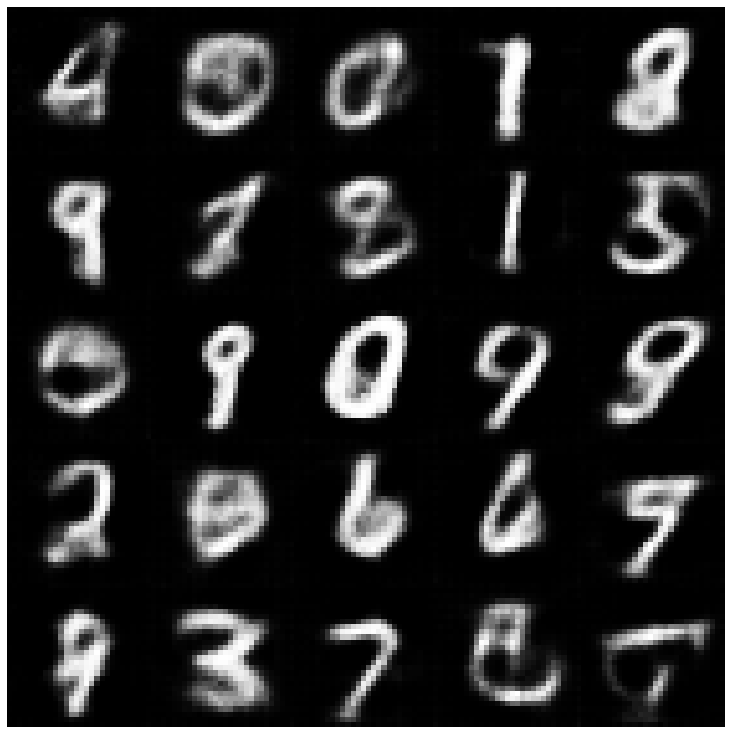

In [63]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().reshape(28, 28), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)